# Introduction to DiffPrivLib

[DiffPrivLib](https://diffprivlib.readthedocs.io/en/latest/index.html) is a python library dedicated to differential privacy and machine learning. It is based on `scikit-learn` library. 

Some other [introduction notebooks](https://github.com/IBM/differential-privacy-library/tree/main/notebooks) are available directly in the official library repository.

## Step 1: Install the Library

Diffprivlib is available on pypi, it can be installed via the pip command. We will use the latest version of the library to date: version 0.6.6.

In [1]:
!pip install diffprivlib==0.6.6

Defaulting to user installation because normal site-packages is not writeable


## Step 2: Load and Prepare Data

### Load penguin dataset
In this notebook, we will work with the [penguin dataset]("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv") from [seaborn datasets](https://github.com/mwaskom/seaborn-data).
We load the dataset via pandas in a dataframe `df`.

In [2]:
import pandas as pd

In [3]:
path_to_data = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"
df = pd.read_csv(path_to_data)

We can look at the first rows of the dataframe to get to know the data:

In [4]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


### Handle null values
DiffPrivLib does not allow null values so we will have to remove or convert them. For simplicity, we will just drop the rows with null values from the dataset.

In [5]:
print(f"{df.shape[0]} rows before dropping nulls")
df = df.dropna()
print(f"{df.shape[0]} rows after dropping nulls")

344 rows before dropping nulls
333 rows after dropping nulls


### Encode columns for Machine Learning

In the following analysis, we will use the `sex` column as a feature column. We encode the `MALE` and `FEMALE` strings in numbers that the models will the able to use.

In [6]:
df["sex"] = df["sex"].map({"MALE": 0, "FEMALE": 1})

In [7]:
df.head(2)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,1


## Step 3: Logistic Regression with DiffPrivLib

We want to predict penguin's species based on bill length, bill depth, flipper length, body mass and sex. 
Therefore, we will do a multiclass logistic regression.

We first split the data between features and target (to predict).

In [8]:
feature_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']
target_columns = ['species']

In [9]:
feature_data = df[feature_columns]
label_data = df[target_columns]

And then split the data to get a training and a testing set with the [train_test_split function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#train-test-split) from scikit-learn.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
TEST_SIZE = 0.2
RANDOM_STATE = 1 

x_train, x_test, y_train, y_test = train_test_split(
    feature_data,
    label_data,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)
y_train = y_train.to_numpy().ravel()

Then we define the logistic regression pipeline [see doc](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#logistic-regression):

In [12]:
from diffprivlib import models

In [13]:
log_reg = models.LogisticRegression(epsilon = 1.0)

And fit it on the training set:

In [14]:
dpl_pipeline = log_reg.fit(x_train, y_train)

/home/bfs/.local/lib/python3.11/site-packages/diffprivlib/models/logistic_regression.py:231: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


### Pipeline with logistic regression only (no standard scaler)

We see that we get a `PrivacyLeakWarning` warning because we did not specify the `data_norm` parameter. 

Differential privacy mechanisms need to know how much one individual’s record can change the model. In the case of the `LogisticRegression`, this depends on the maximum $L2$ norm of any row, which in turn depends on the size of feature vectors. `data_norm` is that bound: The maximum L2 norm of any single row (feature vector) in the dataset. 

If it is not specified, DiffPrivLib will infer if from the training data. This may leak information about the dataset (e.g. what the max value was), hence the PrivacyLeakWarning. To avoid that, we should decide on `data_norm` based on domain knowledge before looking at the data.

As common knowledge (without looking at the data), we know that:
- bill length $\in [30.0, 65.0]$,
- bill depth $\in [13.0, 23.0]$,
- flipper length $\in [150.0, 250.0]$,
- body mass $\in [2000.0, 7000.0]$,
- sex $\in [0, 1]$.

Formally, for a row $x = (x_1, \ldots, x_d)$, its L2 norm is $\|x\|_2 = \sqrt{x_1^2 + x_2^2 + \cdots + x_d^2}$.

The $L2$ norm of a row $x$ can be bounded using the feature maximum values:

$$
\|x\|_2 = \sqrt{ (\text{max bill length})^2 + (\text{max bill depth})^2 + (\text{max flipper length})^2 + (\text{max body mass})^2 + (\text{max sex})^2 }
$$

Writing it in a metadata dictionnary, we can then compute the `data_norm`:

In [15]:
import numpy as np

In [16]:
metadata_bounds = {
    'bill_length_mm': {'lower': 30.0, 'upper': 65.0},
    'bill_depth_mm': {'lower': 13.0, 'upper': 23.0},
    'flipper_length_mm': {'lower': 150.0, 'upper': 250.0},
    'body_mass_g': {'lower': 2000.0, 'upper': 7000.0},
    'sex': {'lower': 0.0, 'upper': 1.0}, 
}

In [17]:
# TODO: compute the data_norm
# data_norm = ...

# Correction
data_norm = np.sqrt(sum(v['upper']**2 for v in metadata_bounds.values()))
print("data_norm =", data_norm)

data_norm = 7004.802281292456


We rewrite the model pipeline with the `data_norm`

In [18]:
log_reg = models.LogisticRegression(epsilon = 1.0, data_norm=data_norm)

Fit it on the training set

In [19]:
log_reg = log_reg.fit(x_train, y_train)

And assess its score (mean accuracy) on the testing set [doc here](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#diffprivlib.models.LogisticRegression.score):

In [20]:
score = log_reg.score(x_test, y_test)
score

0.13432835820895522

### Pipeline with standard scaler before logistic regression

In the previous model, we trained logistic regression without feature scaling.  
Since the features have very different ranges (for example, body mass in the thousands versus sex as a binary 0/1), this can cause several issues:

- the optimizer may converge more slowly  
- model coefficients can become unbalanced  
- in the case of differential privacy, very large row norms can occur, which increases the amount of noise added  

To address this, we will build a pipeline that first scales the data using a 
[`StandardScaler`](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#standard-scaler), and then fits a logistic regression.  

Scaling the features ensures they are on a comparable range, which improves optimization and reduces row norms.  
This leads to better performance and more accurate differentially private estimates.  

#### Step 1 - `StandardScaler`

The `StandardScaler` model standardizes each feature by removing the mean and scaling to unit variance, but unlike scikit-learn’s version, it does this with differential privacy guarantees.

The transformation applied is: 
$$
z = \frac{x - u}{s}.
$$
where:
- $u$ is the differentially private mean
- $s$ is the differentially private standard deviation

Unlike logistic regression, the `StandardScaler` does not take a `data_norm` parameter. Instead, it requires `bounds` for each feature in order to determine the sensitivity and calibrate the amount of noise to add.  

For a given feature, the sensitivity is defined as $sens = \text{max} - \text{min}$.

For example, consider the feature `bill_length_mm` with bounds in $[30.0, 65.0]$, the sensitivity is $sens = 65.0 - 30.0 = 35.0$.

If we use the Laplace mechanism, the privatized query for this feature would be  

$$
M(S) = q(S) + \text{Lap}\left(0, \frac{35.0}{\epsilon}\right)
$$

where $\epsilon$ is the privacy budget.

This ensures the mean and standard deviation are privatized, while the transformed data itself is not differentially private.

First, we have to find the input feature data bounds of the standard scaler. Use the `get_bounds` function to instantiate them.

In [21]:
def get_bounds(metadata_bounds, columns):
    lower = [metadata_bounds[col]["lower"] for col in columns]
    upper = [metadata_bounds[col]["upper"] for col in columns]
    return (lower, upper)

In [22]:
# TODO: compute the feature_bounds of the input data
# feature_bounds = get_bounds(..., ...)

# Correction
feature_bounds = get_bounds(metadata_bounds, columns=feature_columns)
feature_bounds

([30.0, 13.0, 150.0, 2000.0, 0.0], [65.0, 23.0, 250.0, 7000.0, 1.0])

We then instantiate and train the `StandardScaler`:

In [23]:
scaler = models.StandardScaler(epsilon = 0.5, bounds= feature_bounds)
scaler = scaler.fit(x_train)

And transform the data with the trained scaler:

In [24]:
scaled_train_data = scaler.transform(x_train)
scaled_test_data = scaler.transform(x_test)

#### Step 2 - `LogisticRegression`
After scaling, we apply a differentially private logistic regression classifier.

This step requires a parameter called `data_norm`, which is an upper bound on the $L2$ norm of the input rows. However, because the features have first been transformed by the StandardScaler, we cannot simply reuse the original data bounds. Instead, we must compute a new data_norm that reflects the scaled data.

Why a new data_norm?
- The StandardScaler transformed each feature as $z = \frac{x - u}{s}$.
- This changes the feature ranges, so the row norms (and their maximum possible value) also change.
- To guarantee privacy correctly, we must compute the worst-case row norm after this transformation, based on:
    - the original feature bounds,
    - and the privatized mean and variance learned by the scaler.

The new scaled bounds for each feature are obtained by applying the transformation to the original bounds. The maximum possible $L2$ norm across these bounds becomes the new data_norm to use in logistic regression.

We retrive the trained model parameters (mean $u$ and variance $s^2$). They are available in the trained object with one value per feature:

In [25]:
means = scaler.mean_
for col, u in zip(feature_columns, means):
    print(f"Mean of {col} is {u}.")

Mean of bill_length_mm is 45.087184971291606.
Mean of bill_depth_mm is 16.862897986870106.
Mean of flipper_length_mm is 208.3576512005266.
Mean of body_mass_g is 3026.395770475837.
Mean of sex is 0.6007407017484941.


In [26]:
# TODO: Look at the StandardScaler documentation
# variance = get_bounds(..., ...)

# Correction
variances = scaler.var_
for col, s in zip(feature_columns, variances):
    print(f"Variance of {col} is {s}.")

Variance of bill_length_mm is 192.39140184467638.
Variance of bill_depth_mm is 17.02179749263881.
Variance of flipper_length_mm is 379.474042105188.
Variance of body_mass_g is 2805346.901983085.
Variance of sex is 0.07997044284808691.


And compute the new scaled bounds:

In [27]:
def get_scaled_bounds(feature_bounds, means, variances):
    """
    Compute new feature bounds after applying a StandardScaler transform:
        z = (x - u) / s

    Args:
        feature_bounds: tuple (lower_bounds, upper_bounds), each a list of floats
        means: list of feature means (u)
        variances: list of feature variances
    Returns:
        scaled_bounds: tuple (scaled_lower_bounds, scaled_upper_bounds), each a list of floats
    """
    lower, upper = feature_bounds
    stds = np.sqrt(variances)

    scaled_lower = []
    scaled_upper = []

    for l, u, mean, std in zip(lower, upper, means, stds):
        z_lower = (l - mean) / std
        z_upper = (u - mean) / std
        scaled_lower.append(min(z_lower, z_upper))
        scaled_upper.append(max(z_lower, z_upper))

    return (scaled_lower, scaled_upper)

In [28]:
feature_bounds = get_bounds(metadata_bounds, columns=feature_columns)
scaled_bounds = get_scaled_bounds(feature_bounds, means, variances)

In [29]:
# TODO: compute the scaled_data_norm
# scaled_data_norm = ...

# Correction
after_scaler_data_norm = np.sqrt(sum(v**2 for v in scaled_bounds[1]))
print("after_scaler_data_norm =", after_scaler_data_norm)

after_scaler_data_norm = 4.0577228717524525


Now, we initialise the new classifiction model and train it on the scaled train data:

In [30]:
classifier =  models.LogisticRegression(epsilon = 1.0, data_norm = after_scaler_data_norm)
classifier = classifier.fit(scaled_train_data, y_train)

We can look at the intercepts and estimated coefficients for the linear regression problem:

In [31]:
intercepts = classifier.intercept_
print(f"There are {len(intercepts)}, one for each species.")
print(f"Intercepts: {intercepts}")

There are 3, one for each species.
Intercepts: [9.56174275 9.68001776 4.24042952]


In [32]:
coefficients = classifier.coef_
print(f"The table of coefficient has of shape {coefficients.shape}, which corresponds to our 3 target species and {len(feature_columns)} features.")
print(f"Coefficients: {coefficients}")

The table of coefficient has of shape (3, 5), which corresponds to our 3 target species and 5 features.
Coefficients: [[ -3.40427088   2.9602499    1.44786813 -10.70537724  -4.06252585]
 [ -0.45322238   4.560486     8.11415878  -8.59418638   2.10941039]
 [  1.37347558   7.50910146   3.72545897  -7.22169519   2.10200851]]


We can evaluate the score of the model on the test data as well:

In [33]:
score = classifier.score(scaled_test_data, y_test)
score

0.3880597014925373

According to the [documentation](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#diffprivlib.models.LinearRegression.score), the `score` of the logistic regression is the coefficient of determination ($R^2$ score).
It measures how well a model’s predictions approximate the true values.  
$$
R^2 = 1 - \frac{SS_{res}}{SS_{tot}}
$$

where:  

- $SS_{res} = \sum (y_\text{true} - y_\text{pred})^2$ 
  *Residual Sum of Squares* (errors left after fitting the model).  
- $SS_\text{tot} = \sum (y_\text{true} - \bar{y})^2$
  *Total Sum of Squares* (total variance in the data, relative to the mean).  

#### Step 3 - `Pipeline`
Instead of training the standard scaler and logistic regression separatelly, it is possible to write a `pipeline` which combines the two model in an object.
Write a pipeline with the two models below. 

Note: For this example, we can assume that the `after_scaler_data_norm` computed in step 2 is still valid.

In [34]:
from sklearn.pipeline import Pipeline

In [35]:
# TODO: Complete pipeline and train it on the training data. 
# pipeline_with_scaler = Pipeline([
#    ('scaler', ...),
#    ('classifier', ...)
# ])
# pipeline_with_scaler = dpl_pipeline_with_scaler.fit(..., ...)

# Correction
pipeline_with_scaler = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 0.5, bounds = feature_bounds)),
    ('classifier', models.LogisticRegression(epsilon = 1.0, data_norm = after_scaler_data_norm))
])
pipeline_with_scaler = pipeline_with_scaler.fit(x_train, y_train)

And evaluate the score of this new model on the test data:

In [36]:
# TODO: Evaluate the score of this new pipeline
# sc_score = ...

# Correction
sc_score = pipeline_with_scaler.score(x_test, y_test)
sc_score

0.417910447761194

### Privacy loss budget accountant

Another important parameter in DiffPrivLib is an `accountant`. It enables to track the spent budget accross multiple steps in a pipeline and/or accross multiple pipelines.

Therefore the same `accountant` instance of `BudgetAccountant` must be provided as input argument of the query. 

We rewrite here the previous pipeline with the `accountant`.

In [37]:
from diffprivlib import BudgetAccountant

In [38]:
accountant = BudgetAccountant()

pipeline_with_scaler = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 0.5, bounds=feature_bounds, accountant=accountant)),
    ('classifier', models.LogisticRegression(epsilon = 1.0, data_norm=after_scaler_data_norm, accountant=accountant))
])

With the `.total()` method, we can see the budget spent by the models. For now it was not fitted on the data so the budget is 0.

In [39]:
accountant.total()

(epsilon=0, delta=0.0)

We train the model on the data and check the budget again:

In [40]:
pipeline_with_scaler = pipeline_with_scaler.fit(x_train, y_train)
accountant.total()

(epsilon=1.5, delta=0.0)

As expected the budget from both steps is spent 0.5 + 1.0 = 1.5 epsilon.

### Use the model for prediction

We can use the model to predict a species depending on the feature values. 

We try to predict for three cases on female penguins:
- the smallest possible value for all features (lower bound)
- the biggest possible value for all features (upper bound)
- the medium value for all features

In [41]:
x_to_predict_dict = {}
for col in feature_columns:
    lower = metadata_bounds[col]['lower']
    upper = metadata_bounds[col]['upper']
    midpoint = (lower + upper) / 2
    x_to_predict_dict[col] = [lower, upper, midpoint]

x_to_predict = pd.DataFrame(x_to_predict_dict)
x_to_predict

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,30.0,13.0,150.0,2000.0,0.0
1,65.0,23.0,250.0,7000.0,1.0
2,47.5,18.0,200.0,4500.0,0.5


In [42]:
predictions = pipeline_with_scaler.predict(x_to_predict)
x_to_predict["predictions"] = predictions
x_to_predict

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,predictions
0,30.0,13.0,150.0,2000.0,0.0,Gentoo
1,65.0,23.0,250.0,7000.0,1.0,Adelie
2,47.5,18.0,200.0,4500.0,0.5,Gentoo


## Step 4: Clustering KMeans

DiffPrivLib also allows to use K-Means clustering models [(see doc)](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#k-means). 

We will do 6 clusters on the features 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g' and 'sex' and see which what cluster emerges. As it is unsupervised learning, there is no target column and in this step, we do not do a training and testing set. 

In [43]:
N_CLUSTERS = 6
feature_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']
feature_data = df[feature_columns]

### StandardScaler and KMeans Pipeline
Therefore, we will first do a pipeline with a `StandardScaler` followed by `KMeans`, which will look like this:

In [44]:
accountant = BudgetAccountant()
demo_pipeline = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 0.5, bounds=..., accountant=accountant)),
    ('kmeans', models.KMeans(n_clusters = N_CLUSTERS, epsilon = 5.0, bounds=..., accountant=accountant)),
])

As before, we need to determine all required parameter to avoid `PrivacyLeakWarning`. For the `StandardScaler`, we get some input bounds from the metadata:

In [45]:
feature_bounds = get_bounds(metadata_bounds, columns=feature_columns)
feature_bounds

([30.0, 13.0, 150.0, 2000.0, 0.0], [65.0, 23.0, 250.0, 7000.0, 1.0])

And can you derive the bounds of `K_Means` ?

Hint: You can use a similar logic as before with `get_scaled_bounds` and the previously computed `means` and `variances`. Be careful, the bounds must be provided as a tuple of the form (min, max), like `feature_bounds` above.

In [46]:
# TODO: Instantiate the bounds after the `StandardScaler`
# after_scaler_bounds = ...

# Correction
after_scaler_bounds = get_scaled_bounds(feature_bounds, means, variances)

You have now everything to instantiate this pipeline:

In [47]:
# TODO: Instantiate the `kmeans_pipeline` taking example on the `demo_pipeline above`
# kmeans_pipeline = ...

# Correction
kmeans_pipeline = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 0.5, bounds=feature_bounds, accountant=accountant)),
    ('kmeans', models.KMeans(n_clusters = N_CLUSTERS, epsilon = 5.0, bounds=after_scaler_bounds, accountant=accountant)),
])

Let's fit the K-Meand model on the clusters

In [48]:
# TODO: Fit the K-Mean pipeline
# kmeans_pipeline = ...

# Correction
kmeans_pipeline = kmeans_pipeline.fit(feature_data)
kmeans_pipeline

,steps,"[('scaler', ...), ('kmeans', ...)]"
,transform_input,None
,memory,None
,verbose,False
,epsilon,0.5
,bounds,"(array([ 30.,...2000., 0.]), ...)"
,copy,True
,with_mean,True
,with_std,True
,random_state,None
,accountant,"BudgetAccount...0), (5.0, 0)])"


We can look at the score of the model, which is the opposite of the value of X on the K-means objective.

In [49]:
kmeans_pipeline.score(feature_data)

-406.7487364077843

According to the official [documentation](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#diffprivlib.models.KMeans.score), the `score` of the `K-means` model is the 'opposite of the value of X on the K-means objective'.

Ususally, the K-means objective is the *inertia*, i.e. the within-cluster sum of squared distances:

$$
\text{Inertia} = \sum_{i=1}^n w_i \, \min_{c \in \text{clusters}} \lVert x_i - \mu_c \rVert^2
$$

where:  
- $x_i$ = a data point  
- $\mu_c$ = the centroid of cluster $c$  
- $w_i$ = optional weight for the sample  

The K-means algorithm tries to minimize inertia (tight, well-separated clusters), where smaller is better.

DiffPrivLib is based on scikit-learn and in scikit-learn, by convention, higher scores are always better. Hence, to stay consistent, scikit-learn defines: $\text{score}(X) = - \text{Inertia}(X)$, which represent the same information, just with opposite signs.

We can use the model to predict the clusters:

In [50]:
# TODO: Predict clusters on feature_data with K-Mean pipeline
#predictions = ...

# Correction
predictions = kmeans_pipeline.predict(feature_data)

In [51]:
df["predictions"] = predictions
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,predictions
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0,1
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,1,2
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,1,2
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,1,2
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,0,1


We can plot the results to study the clusters

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
def plot_clusters(df, x, y, cluster_col="predictions", style_col="species"):
    """
    Plot two features colored by cluster predictions and shaped by species.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the features, cluster predictions, and species.
    x : str
        Feature name for the x-axis.
    y : str
        Feature name for the y-axis.
    cluster_col : str, default="predictions"
        Column name with cluster assignments.
    style_col : str, default="species"
        Column name for marker style (e.g., species).
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df,
        x=x,
        y=y,
        hue=cluster_col,
        style=style_col,
        palette="deep",
        s=80
    )
    plt.title(f"DP KMeans Clustering: {x} vs {y}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

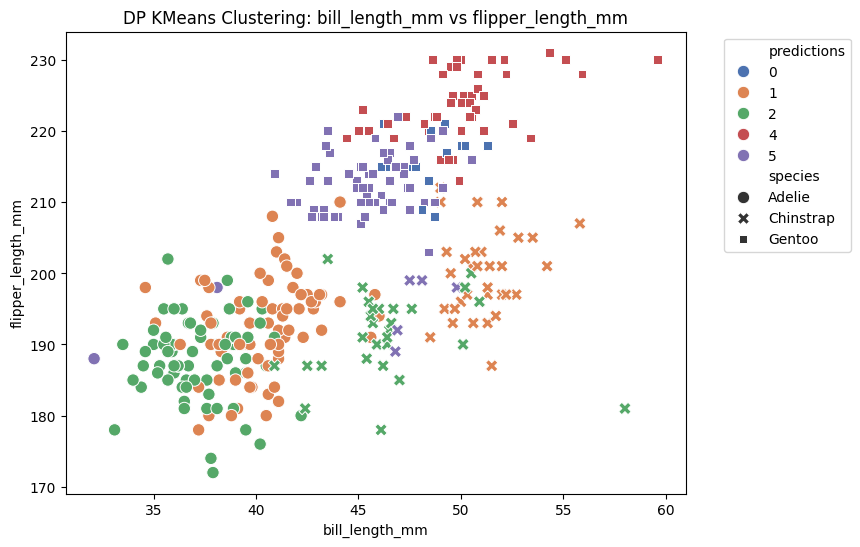

In [54]:
plot_clusters(df, x="bill_length_mm", y="flipper_length_mm")

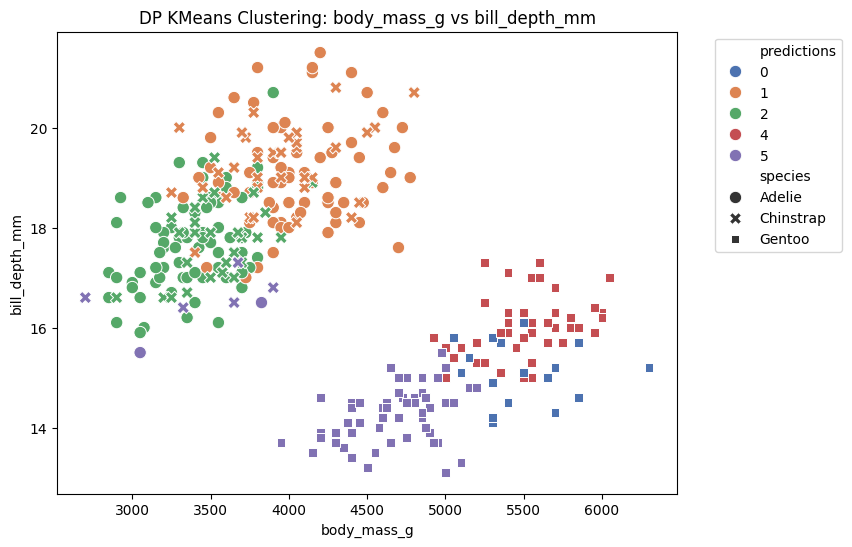

In [55]:
plot_clusters(df, x="body_mass_g", y="bill_depth_mm")

Feel free to try various number of cluster options, feature selection and axis to plot!

### KMeans after PCA and StandardScaler

Let's try do do a dimensionality reduction to two components with a PCA before K-Means to improve the clustering.

The PCA model requires `bounds` and `data_norm` parameters. Using the same logic as before, re-intstantiate the appropriate parameters in a first pipeline with a `StandardScaler` followed by a `PCA` model.

In [56]:
N_COMPONENTS = 2

In [57]:
# TODO: Using what we learned above, re-instantiate the appropriate bounds for the pipeline below
# feature_bounds = ...
# after_scaler_bounds = ...
# after_scaler_data_norm = ...

# Correction
feature_bounds =  get_bounds(metadata_bounds, columns=feature_columns)
after_scaler_bounds = get_scaled_bounds(feature_bounds, means, variances)
after_scaler_data_norm = np.sqrt(sum(v**2 for v in scaled_bounds[1]))

In [58]:
accountant = BudgetAccountant()

pca_pipeline = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 0.5, bounds=feature_bounds, accountant=accountant)),
    ('pca', models.PCA(n_components=N_COMPONENTS, epsilon=3.0, bounds=after_scaler_bounds, data_norm=after_scaler_data_norm, accountant=accountant)),
])

For now we have not spent any budget:

In [59]:
accountant.total()

(epsilon=0, delta=0.0)

We fit the pipeline on the data:

In [60]:
pca_pipeline = pca_pipeline.fit(feature_data)
pca_pipeline

,steps,"[('scaler', ...), ('pca', ...)]"
,transform_input,None
,memory,None
,verbose,False
,epsilon,0.5
,bounds,"(array([ 30.,...2000., 0.]), ...)"
,copy,True
,with_mean,True
,with_std,True
,random_state,None
,accountant,"BudgetAccount...0), (3.0, 0)])"


How much budget have we spent now ?

In [61]:
# TODO: How much budget was spent for this training ? 
# Correction
accountant.total()

(epsilon=3.5, delta=0.0)

In a `pipeline`, each `model` is in a `step`. We can retrieve the PCA model (second step) to look at the some of the trained parameters:

In [62]:
pca_model = pca_pipeline.steps[1][1]
pca_model

,n_components,2
,epsilon,3.0
,data_norm,np.float64(4.0577228717524525)
,centered,False
,bounds,"(array([-1.087... -2.12433159]), ...)"
,copy,True
,whiten,False
,random_state,None
,accountant,"BudgetAccount...0), (3.0, 0)])"


We can look at the amount of variance explained by each of the selected components:

In [63]:
pca_model.explained_variance_

array([7.02927381, 1.54433592])

And the percentage of variance explained by each of the selected components:

In [64]:
pca_model.explained_variance_ratio_

array([0.71864622, 0.15788703])

The per-feature empirical mean:

In [65]:
pca_mean = pca_model.mean_
pca_mean

array([-0.17089279, -0.18599451,  0.76078152,  0.62992887,  0.16664262])

And finally the principal axes in feature space, representing the directions of maximum variance in the data. They will be useful later.

In [66]:
pca_components = pca_model.components_
pca_components

array([[ 0.11911398, -0.08110479,  0.39980457,  0.89667768, -0.12393273],
       [ 0.14460145, -0.31347762,  0.4694101 , -0.14637166,  0.79940709]])

We can use the [transform](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#diffprivlib.models.PCA.transform) method to apply the dimensionality reduction on it on the feature data.

In [67]:
pca_feature_data = pca_pipeline.transform(feature_data)
pca_feature_data.shape

(333, 2)

This outputs 2 columns that we add to our dataframe.

In [68]:
df[["component_1", "component_2"]] = pd.DataFrame(pca_feature_data, index=df.index)
df.head(1)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,predictions,component_1,component_2
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0,1,-1.932805,-1.728337


We now want to train a K-Means clustering on the principal components. 

Once again, we need to determine bounds for the data output of PCA and the input of K-Means. Luckily, we already have everything we need!

In our pipeline, we first applied a `StandardScaler`, which centered all features at 0 and scaled them to unit variance. After this step, each feature has known bounds `after_scaler_bounds`.

PCA then projects the scaled data onto a lower-dimensional space:

$$
Z = X_\text{scaled} \cdot V^T
$$

where:  
- $V$ = PCA components (`PCA.components_`)  
- $Z$ = transformed data in $n_\text{components}=2$ dimensions  

Each PCA component is a linear combination of the scaled features:

$$
z_j = \sum_i V_{j,i} \, (x_i^\text{scaled} - \text{pca\_mean}_i)
$$

where $\text{pca\_mean}_i$ is the mean of the $i$-th feature used internally by PCA.  

If each scaled feature $x_i^\text{scaled}$ lies in a known interval $[l_i, u_i]$, the transformed PCA component $z_j$ will also lie in some interval $[z_j^\text{min}, z_j^\text{max}]$.  
Since $z_j$ is a linear combination of the features, the extreme values of $z_j$ occur when each feature is at either its lower or upper bound.  


By summing these extreme values across all features, we get the lower and upper bounds for $z_j$:

$$
z_j^\text{min} = \sum_i V_{j,i} \cdot 
\begin{cases} 
l_i - \text{pca\_mean}_i & \text{if } V_{j,i} \ge 0 \\ 
u_i - \text{pca\_mean}_i & \text{if } V_{j,i} < 0 
\end{cases}, 
\quad
z_j^\text{max} = \sum_i V_{j,i} \cdot 
\begin{cases} 
u_i - \text{pca\_mean}_i & \text{if } V_{j,i} \ge 0 \\ 
l_i - \text{pca\_mean}_i & \text{if } V_{j,i} < 0 
\end{cases}
$$

In [69]:
def get_pca_bounds(feature_bounds, pca_mean, pca_components):
    """
    Compute PCA component bounds from feature bounds and PCA model.
    
    Args:
        feature_bounds: tuple (lower_bounds, upper_bounds) after scaling
        pca_mean: array-like of shape [n_features], mean of PCA model
        pca_components: array-like of shape [n_components, n_features]
    
    Returns:
        pca_bounds: tuple (lower_bounds, upper_bounds) per PCA component
        max_row_norm: worst-case L2 norm across components
    """
    lower, upper = feature_bounds
    n_components = pca_components.shape[0]
    
    pca_lower = []
    pca_upper = []
    
    for j in range(n_components):
        z_min = 0
        z_max = 0
        for i, V_ji in enumerate(pca_components[j]):
            l_i = lower[i] - pca_mean[i]
            u_i = upper[i] - pca_mean[i]
            if V_ji >= 0:
                z_min += V_ji * l_i
                z_max += V_ji * u_i
            else:
                z_min += V_ji * u_i
                z_max += V_ji * l_i
        pca_lower.append(z_min)
        pca_upper.append(z_max)
    
    return pca_lower, pca_upper

In [70]:
after_pca_bounds = get_pca_bounds(after_scaler_bounds, pca_mean, pca_components)

In [71]:
# TODO: Instantiate a KMeans model with N_CLUSTERS, epsilon as 2.0, the right bounds (it is after the PCA) and the same privacy budget accountant as for the `pca_pipeline`
# kmeans_model = models.KMeans(...)

# Correction
kmeans_model = models.KMeans(n_clusters = N_CLUSTERS, epsilon = 2.0, bounds=after_pca_bounds, accountant=accountant)

In [72]:
# TODO: Fit the KMeans model on the principal components
#kmeans_model = ...

# Correction
kmeans_model = kmeans_model.fit(df[["component_1", "component_2"]])
kmeans_model

,n_clusters,6
,epsilon,2.0
,bounds,"(array([-3.015... -4.50701079]), ...)"
,random_state,None
,accountant,"BudgetAccount...0), (2.0, 0)])"


In [73]:
# TODO: Predict clusters on principal compoents with K-Mean pipeline
# after_pca_predictions = ...

# Correction
after_pca_predictions = kmeans_model.predict(df[["component_1", "component_2"]])

In [74]:
df["after_pca_predictions"] = after_pca_predictions
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,predictions,component_1,component_2,after_pca_predictions
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0,1,-1.932805,-1.728337,5
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,1,2,-1.843780,0.354206,3
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,1,2,-2.896050,0.977125,4
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,1,2,-2.519629,0.660093,4
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,0,1,-1.859552,-1.401285,5


We can now plot the results along the principal components axix:

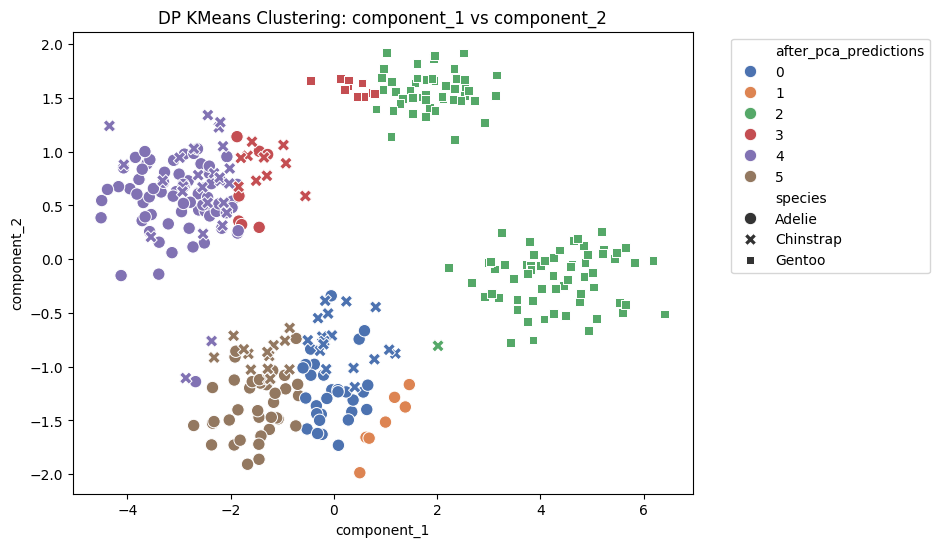

In [75]:
plot_clusters(df, x="component_1", y="component_2", cluster_col="after_pca_predictions")

Again, feel free to try various number of principal components, cluster options, feature selection and axis to plot!

Let's now check what was the total budget spent by the scaler, pca and k-means models.

In [76]:
# TODO: Get epsilon and delta (hint: use the accountant)
# Correction
accountant.total()

(epsilon=5.5, delta=0.0)

## Step 5: On your Own

DiffPrivLib also provides additional models:
- Gaussian Naive Bayes, 
- Random Forest Classifier,
- Decision Tree Classifier and
- Linear Regressions.

Using these models is very similar to the examples shown here. Apart from the parameters already introduced (`epsilon`, `bounds` and `data_norm`), no additional differentially private settings are required.

Feel free to experiment with these models on your own!